# 거리에 따른 diff가 크지 않다라고 가정하고 상봉동 - OA200_2, 상대동 - OA200_1과 비교하여 OA200 데이터를 약간 조정한 데이터 프레임 만들기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from matplotlib import font_manager, rc
import warnings

# plt parameter 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [25,15]
plt.rcParams['font.size'] = 25

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [2]:
# outliar 제거 함수 (IQR 설정) (1)
def remove_out(dataframe, remove_col) :
    dff = dataframe
    for k in remove_col :
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 1.5
        outliar_h = dff[k] >= level_3q + (rev_range * IQR)
        outliar_l = dff[k] <= level_1q - (rev_range * IQR)
        a=dff[outliar_h].index
        b=dff[outliar_l].index
        dff.drop(a, inplace=True)
        dff.drop(b, inplace=True)

# pm25값이 최대인 인덱스를 찾아 빼는 함수, 2번 함수가 잘 적용되는지 확인하기 위한 용도
def find_max_value_pm25(data1, data2) :
    max_index = data1['pm25'].idxmax()
    arim = data1.loc[max_index, 'pm25'] # data1의 max값의 날짜에 맞는 pm25값
    arim_date = max_index # max_index값이 날짜로 설정되어 있으므로
    air = data2.loc[data2.index == arim_date] # data1와 같은 날짜 찾기
    return abs(air.pm25 - arim) # arim data와 air data의 pm25[max]값 차이

# pm10값이 최대인 인덱스를 찾아 빼는 함수, 2번 함수가 잘 적용되는지 확인하기 위한 용도
def find_max_value_pm10(data1, data2) :
    max_index = data1['pm10'].idxmax()
    arim = data1.loc[max_index, 'pm10'] # data1의 max값의 날짜에 맞는 pm25값
    arim_date = max_index # max_index값이 날짜로 설정되어 있으므로
    air = data2.loc[data2.index == arim_date] # data1와 같은 날짜 찾기
    return abs(air.pm10 - arim) # arim data와 air data의 pm25[max]값 차이


#그래프 2개 비교 (차이 비교)
def difference_abs(dataframe1, dataframe2) :    
    diff = abs(np.subtract(dataframe1,dataframe2))
    # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정

    plt.plot(dataframe1.index,diff)
    for i in range(len(dataframe1.index)):
        height = diff[i]
        plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
    plt.title("Difference between airm-airKorea")
    plt.xlabel("Hour")
    plt.ylabel("diff")
    plt.show()

#그래프 2개 비교 (차이 비교) -- 숫자를 표시안함
def difference(dataframe1, dataframe2) :    
    diff = np.subtract(dataframe1,dataframe2)
    # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정

    plt.plot(dataframe1.index,diff)
#     for i in range(len(dataframe1.index)):
#         height = diff[i]
#         plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
    plt.title("Difference between airm-airKorea")
    plt.xlabel("Hour")
    plt.ylabel("diff")
    plt.show()
    


# 오차 구해서 그래프로 (dataframe1과 dataframe2는 범위를 설정해야함) dataframe1 = airKorea, dataframe2 = arim (4)
def errorRate(dataframe1, dataframe2) :
    diff = abs(np.subtract(dataframe1, dataframe2))
    result = (diff/dataframe1)*100
    result = result.to_frame(name='errorRate') # series type인 result를 dataframe으로 변환한 후, errorRate 열 추가
    
    # errorRate가 100 이상인 index를 추출하여 호출
    if any(result['errorRate'] >= 100) :
        errorRate100 = result[result['errorRate'] >= 100]['errorRate']
        print(errorRate100)
        print('##########arimData##########')
        print(arim_data_avg.loc[errorRate100.index.tolist()])
        print('##########airKorea Data##########')
        print(airKorea_data_avg.loc[errorRate100.index.tolist()])
    
    plt.plot(dataframe1.index,result['errorRate'])
    for i in range(len(dataframe1.index)):
        height = result.iloc[i]['errorRate']
        plt.text(dataframe1.index[i], height + 0.01, '%.2f %%' %height, ha='center', va='bottom', size = 25)
    plt.title("error rate between airKorea-arim")
    plt.xlabel("Hour")
    plt.ylabel("error rate(%)")
    plt.ylim([0,100])
    plt.show()

# 새로운 함수 -> 이것은 arim data가 airKorea data의 pm2.5보다 크거나 작은 값의 특징을 알아보기 위해 만들었음.
def find_condition(dataframe1, dataframe2) :
    diff = np.subtract(dataframe1.pm25, dataframe2.pm25)
    diff = diff.to_frame(name='difference')

    arimDown = dataframe2.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
    airKoreaUp = dataframe1.loc[diff.loc[diff['difference']>0].index]
    
    arimUp = dataframe2.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
    airKoreaDown = dataframe1.loc[diff.loc[diff['difference']<0].index]

    arimUp.name = 'arimUp'
    arimDown.name = 'arimDown'
    airKoreaUp.name = 'airKoreaUp'
    airKoreaDown.name = 'airKoreaDown'
    
    fig, axes = plt.subplots(2,2, figsize=(50,20))
    cat_features = [arimUp, airKoreaDown, arimDown, airKoreaUp]
    for i, feature in enumerate(cat_features) :
        row = int(i/2)
        col = i%2
        if 'humi' in feature.columns :
            axes[row,col].plot(feature.index,feature.humi)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['humi']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("humi")
            axes[row,col].grid(visible=True)
        else : 
            axes[row,col].plot(cat_features[i-1].index,cat_features[i-1].temp)
            for j in range(len(cat_features[i-1].index)):
                height = cat_features[i-1].iloc[j]['temp']
                axes[row,col].text(cat_features[i-1].index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(cat_features[i-1].name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("temp")
            axes[row,col].grid(visible=True)

# 새로운 함수 -> 이것은 arim data가 airKorea data의 pm2.5보다 크거나 작은 값의 특징을 알아보기 위해 만들었음.
def find_condition_pm25(dataframe1, dataframe2) :
    diff = np.subtract(dataframe1.pm25, dataframe2.pm25)
    diff = diff.to_frame(name='difference')

    arimDown = dataframe2.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
    airKoreaUp = dataframe1.loc[diff.loc[diff['difference']>0].index]
    
    arimUp = dataframe2.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
    airKoreaDown = dataframe1.loc[diff.loc[diff['difference']<0].index]

    arimUp.name = 'arimUp'
    arimDown.name = 'arimDown'
    airKoreaUp.name = 'airKoreaUp'
    airKoreaDown.name = 'airKoreaDown'
    
    fig, axes = plt.subplots(2,2, figsize=(50,20))
    cat_features = [arimUp, airKoreaDown, arimDown, airKoreaUp]
    for i, feature in enumerate(cat_features) :
        row = int(i/2)
        col = i%2
        if 'humi' in feature.columns :
            axes[row,col].plot(feature.index,feature.pm25)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['pm25']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("pm25")
            axes[row,col].set_ylim(0,100)
            axes[row,col].grid(visible=True)
        else : 
            axes[row,col].plot(feature.index,feature.pm25)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['pm25']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("pm25")
            axes[row,col].set_ylim(0,100)
            axes[row,col].grid(visible=True)
    
def adjustment_arim() :
    diff = np.subtract(dataframe1.pm25, dataframe2.pm25)
    diff = diff.to_frame(name='difference')

    arimDown = dataframe2.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
    airKoreaUp = dataframe1.loc[diff.loc[diff['difference']>0].index]
    
    arimUp = dataframe2.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
    airKoreaDown = dataframe1.loc[diff.loc[diff['difference']<0].index]

    arimUp.name = 'arimUp'
    arimDown.name = 'arimDown'
    airKoreaUp.name = 'airKoreaUp'
    airKoreaDown.name = 'airKoreaDown'

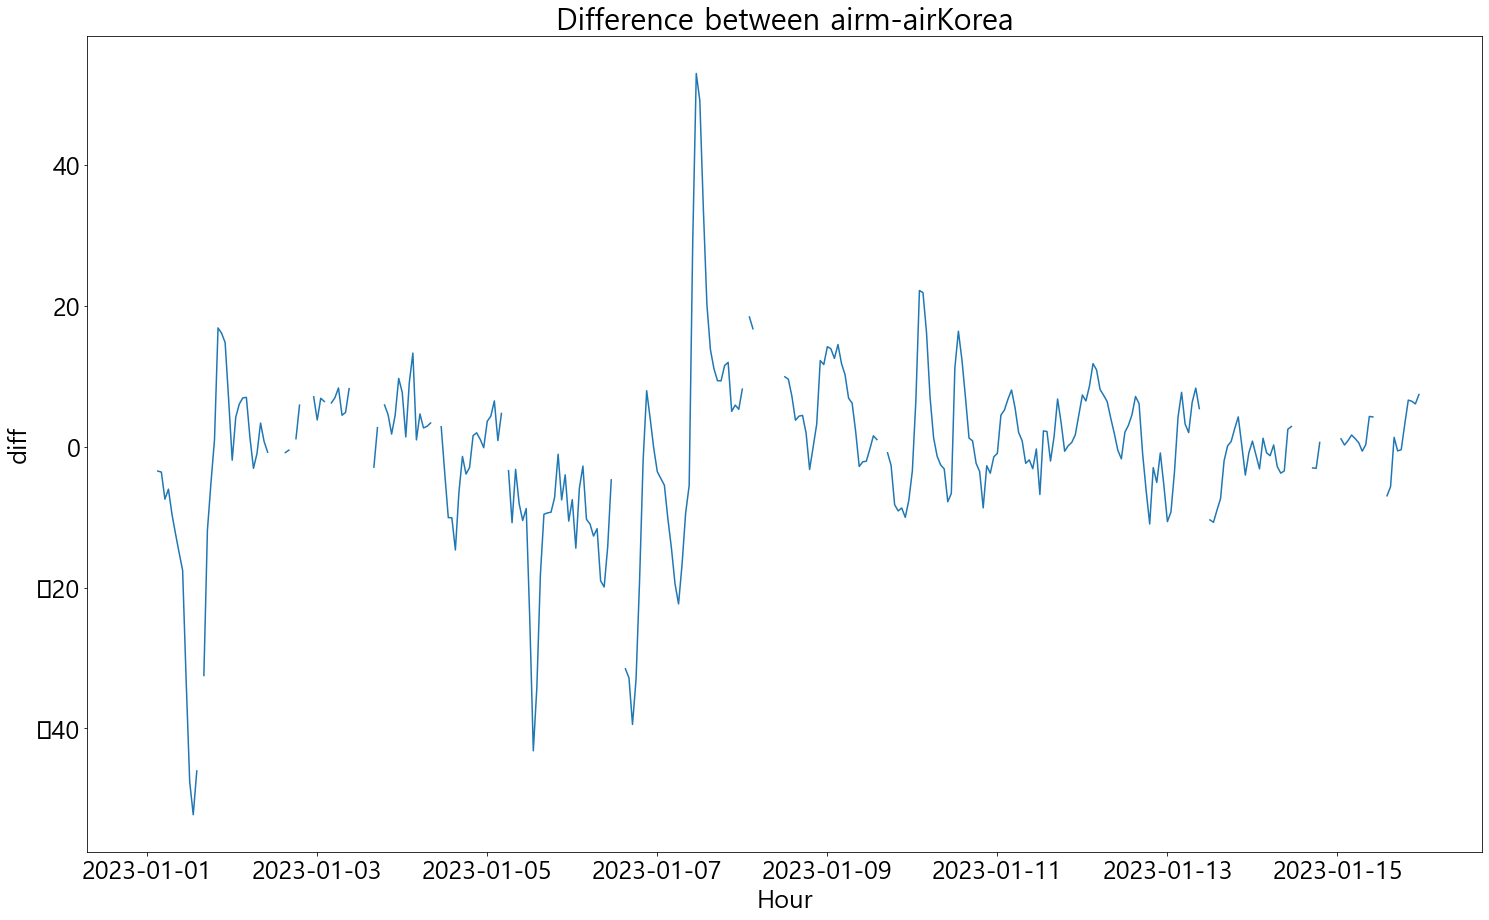

In [15]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

difference(airKorea_data_avg.pm25, arim_data_avg.pm25)

                               no       pm25       pm10      temp       humi
reg_date                                                                    
2023-01-01 01:00:00  9.293218e+05  18.623333  27.520000  1.888333  53.793333
2023-01-01 02:00:00  9.304000e+05  28.838333  29.036667  1.238333  54.196667
2023-01-01 03:00:00  9.314796e+05  19.696667  28.645000  0.726667  54.510000
2023-01-01 04:00:00  9.325590e+05  18.843333  27.801667  0.311667  54.828333
2023-01-01 05:00:00  9.336390e+05  19.690000  28.635000 -0.071667  55.715000
...                           ...        ...        ...       ...        ...
2023-01-15 19:00:00  1.368519e+06  15.581667   6.845000  6.325000  49.818333
2023-01-15 20:00:00  1.370705e+06  15.140000   6.415000  5.930000  46.035000
2023-01-15 21:00:00  1.372847e+06  15.301667   6.596667  4.960000  43.571667
2023-01-15 22:00:00  1.374937e+06  14.678333   5.990000  4.286667  43.653333
2023-01-15 23:00:00  1.377033e+06  14.345000   5.686667  3.566667  42.280000

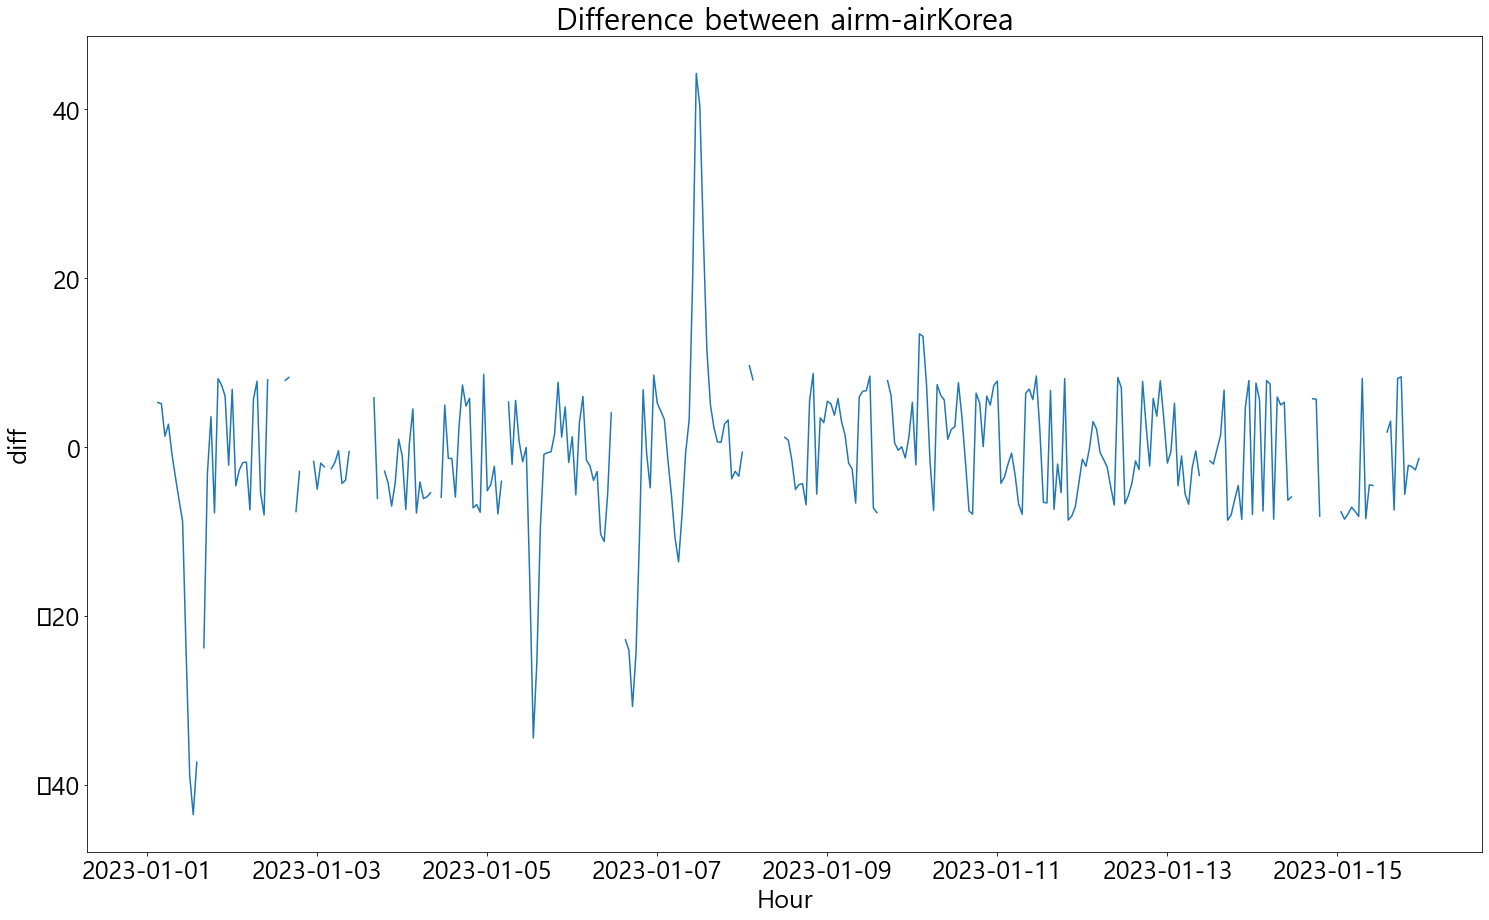

In [18]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

diff = np.subtract(airKorea_data_avg.pm25, arim_data_avg.pm25)
diff = diff.to_frame(name='difference')

arimDown = arim_data_avg.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
airKoreaUp = airKorea_data_avg.loc[diff.loc[diff['difference']>0].index]

arimUp = arim_data_avg.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
airKoreaDown = airKorea_data_avg.loc[diff.loc[diff['difference']<0].index]


#difference(arimUp.pm25, airKoreaDown.pm25)
a = arimUp.pm25 - airKoreaDown.pm25
a.mean()
arimDown.pm25 += 8.76
arimUp.pm25 -= 8.76

# 새로운 DataFrame을 만들어서 수정된 값을 저장
arim_data_avg_updated = arim_data_avg.copy()
arim_data_avg_updated.loc[arimDown.index, 'pm25'] = arimDown.pm25
arim_data_avg_updated.loc[arimUp.index, 'pm25'] = arimUp.pm25

print(arim_data_avg_updated)

difference(airKorea_data_avg.pm25, arim_data_avg_updated.pm25)

### arim의 공기질 나쁨 상태일 때의 데이터 비교 - 결론(높은 값에서도 20이상 오차가 생기는 경우가 존재함)
### 결론 2(높은 값에서는 OA200 데이터가 무조건 큰 값만 나올줄 알았는데 아니었음.)

10.521959142896513


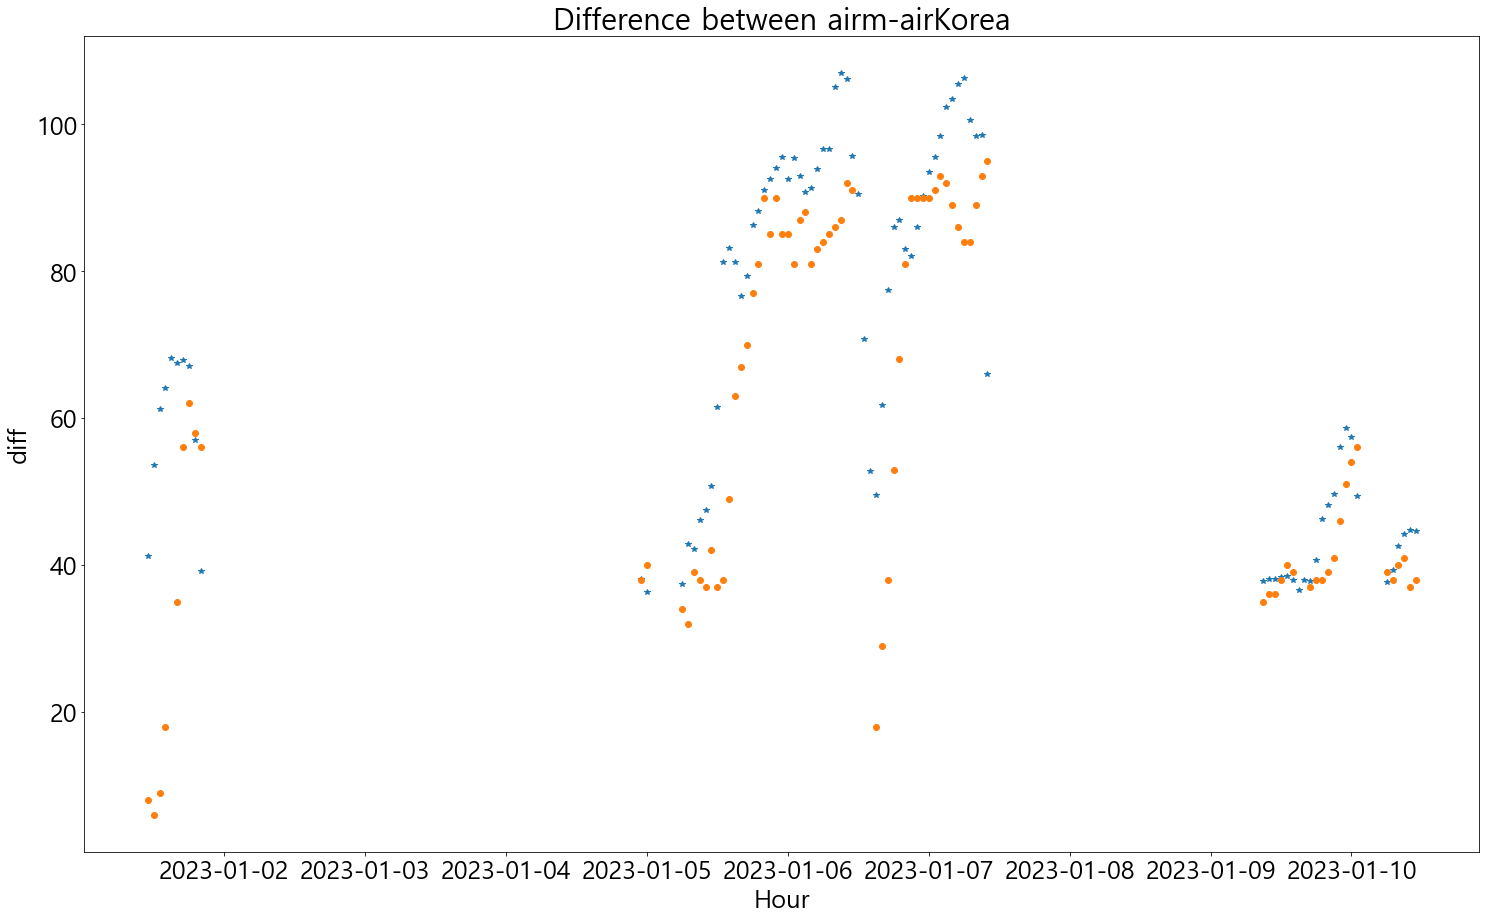

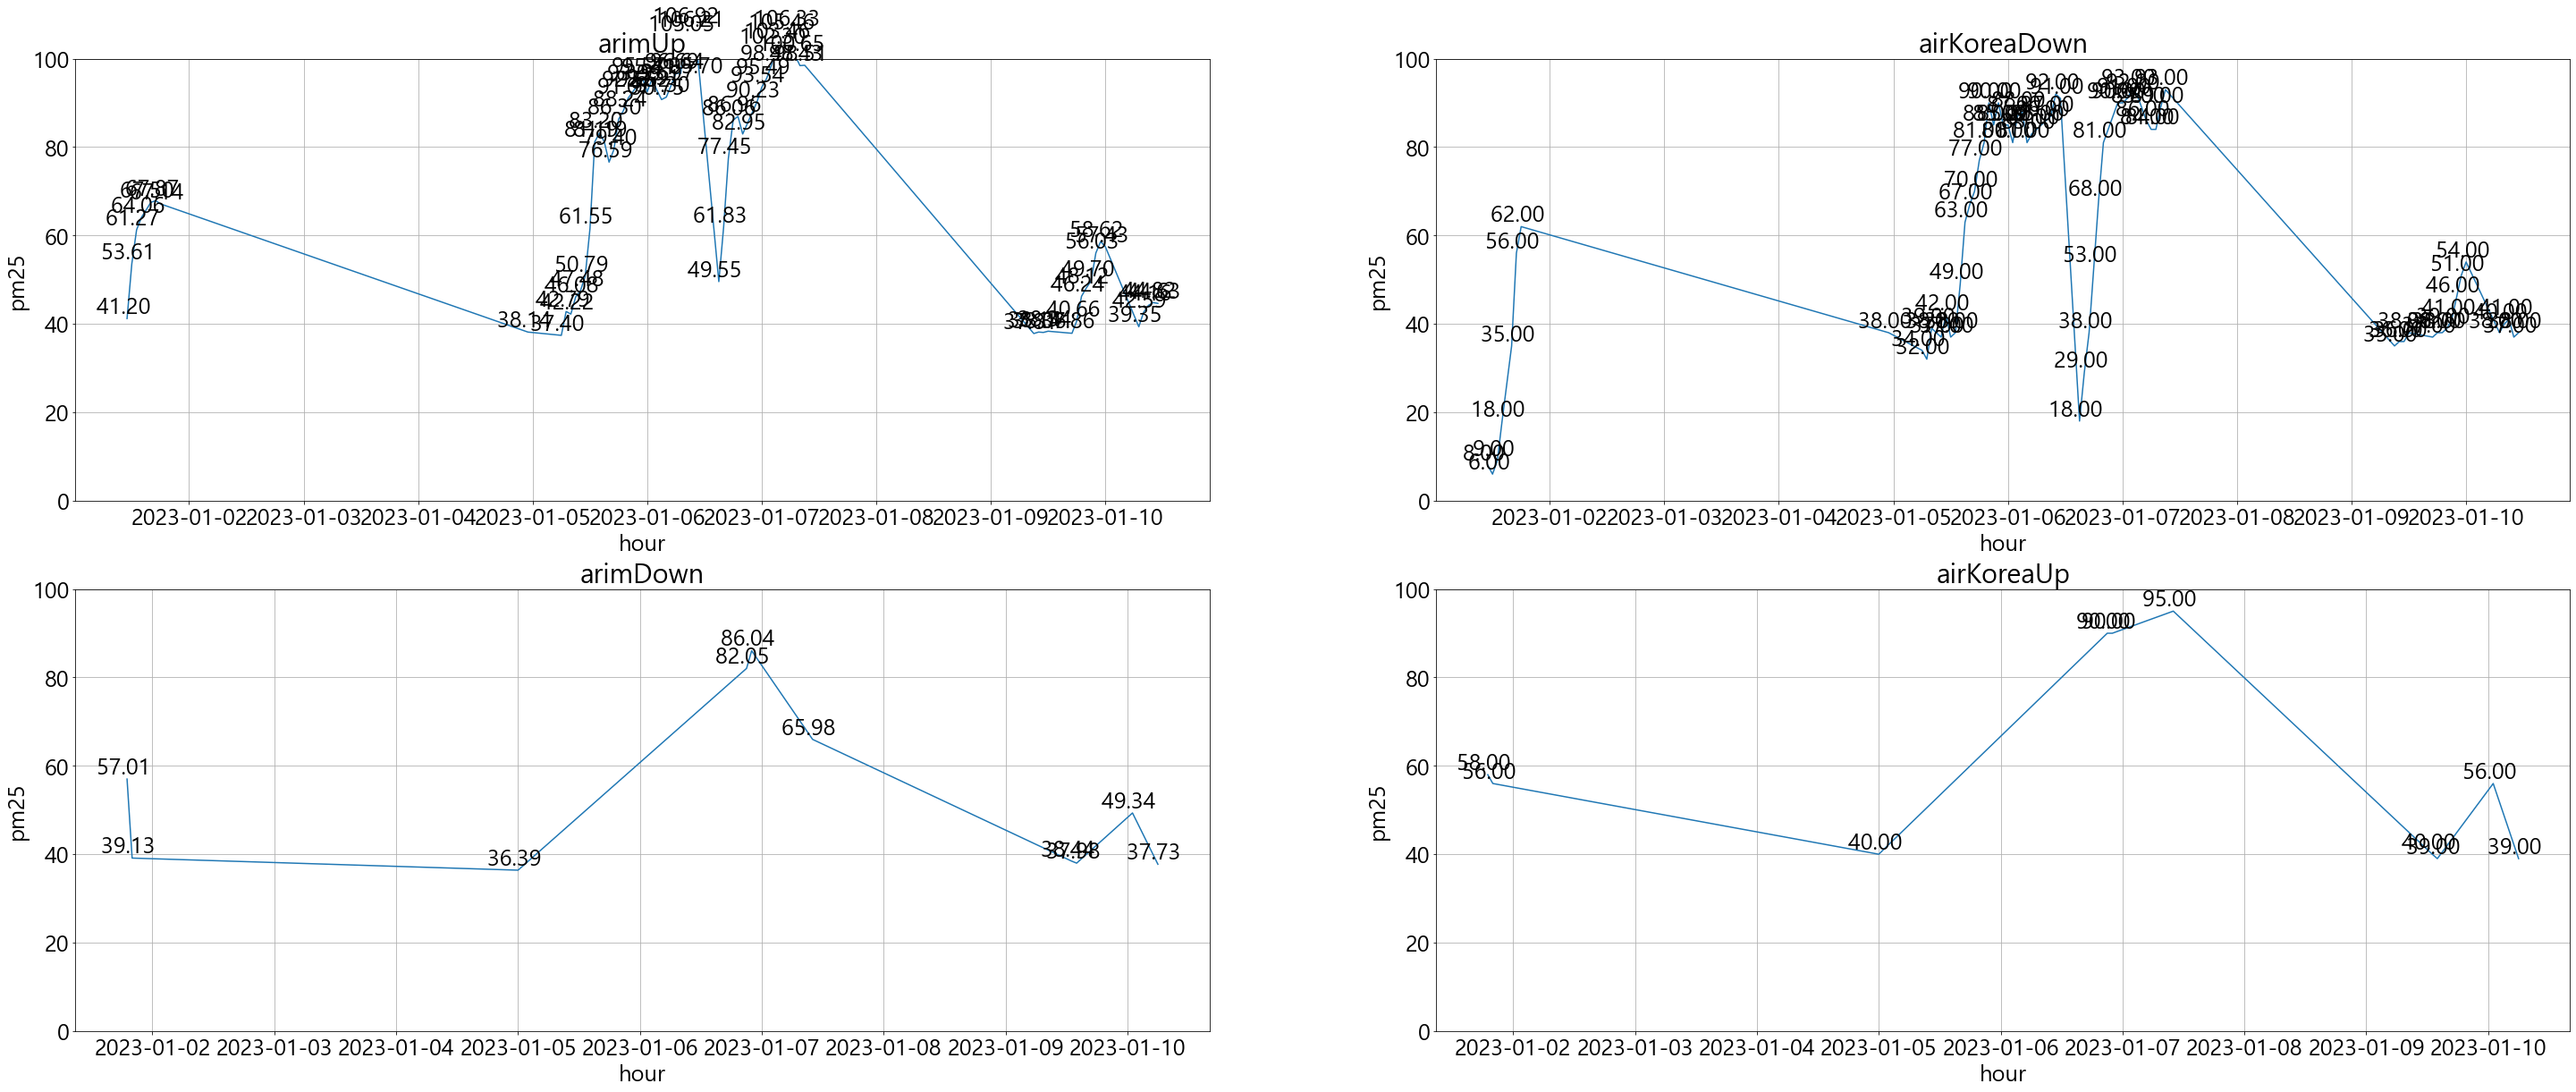

In [8]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()

# remove_out(arim_data_avg, ['pm25'])

# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# remove_out(airKorea_data_avg, ['pm25'])

# arim_data_avg.drop('2023-01-07 10:00:00', inplace=True)
arimDown = arim_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
airKoreaUp = airKorea_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index]

diff = arimDown.pm25 - airKoreaUp.pm25
print(diff.mean())

plt.plot(arimDown.index,arimDown.pm25,'*', arimDown.index, airKoreaUp.pm25, 'o')
plt.title("Difference between airm-airKorea")
plt.xlabel("Hour")
plt.ylabel("diff")
plt.show()

find_condition_pm25(airKoreaUp, arimDown)

4.078095238095239


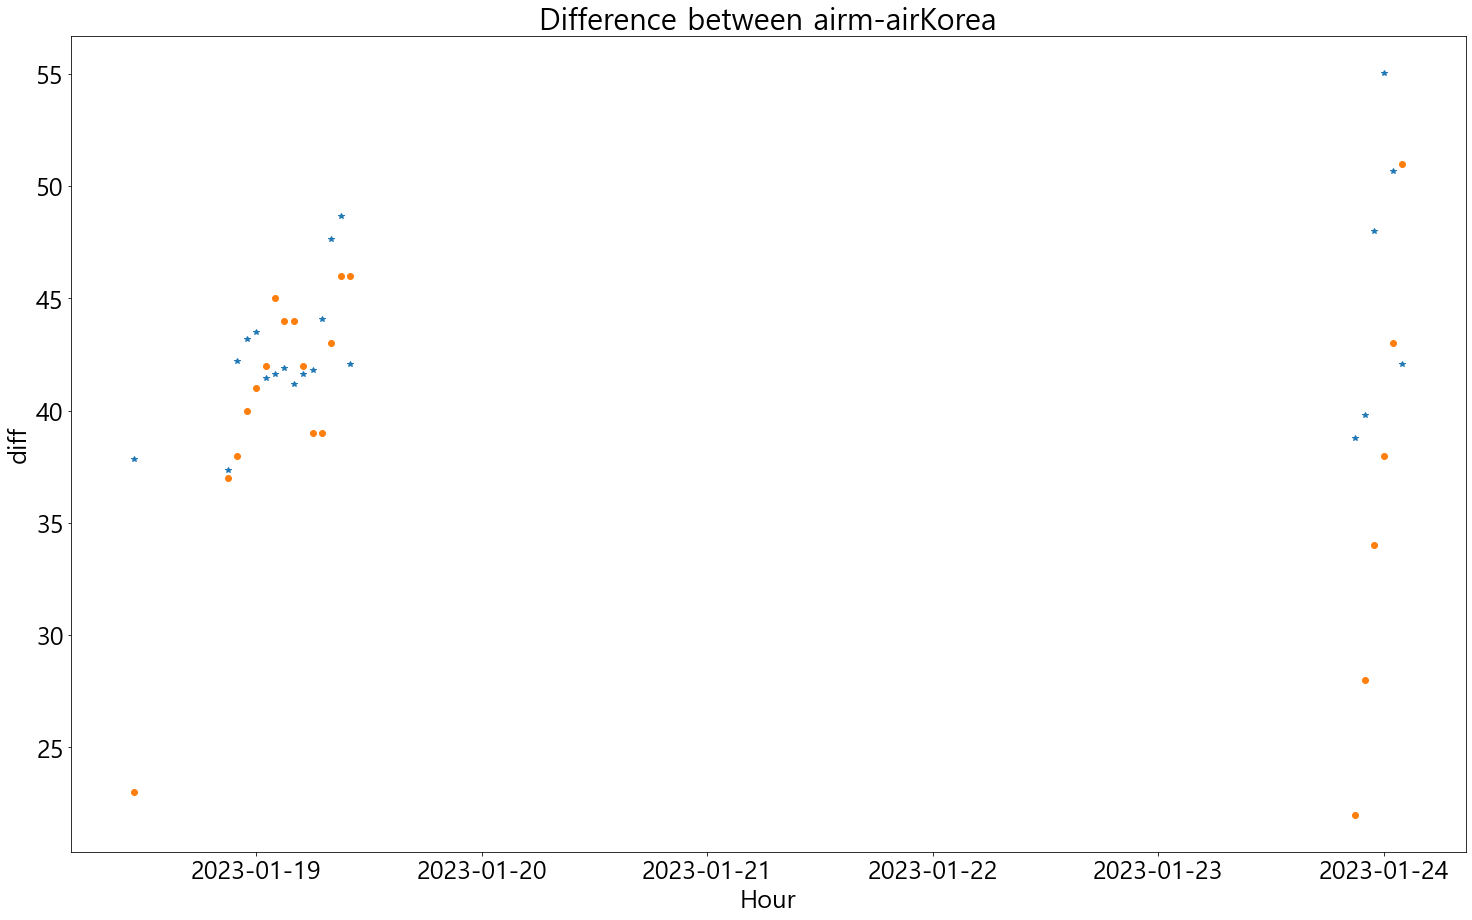

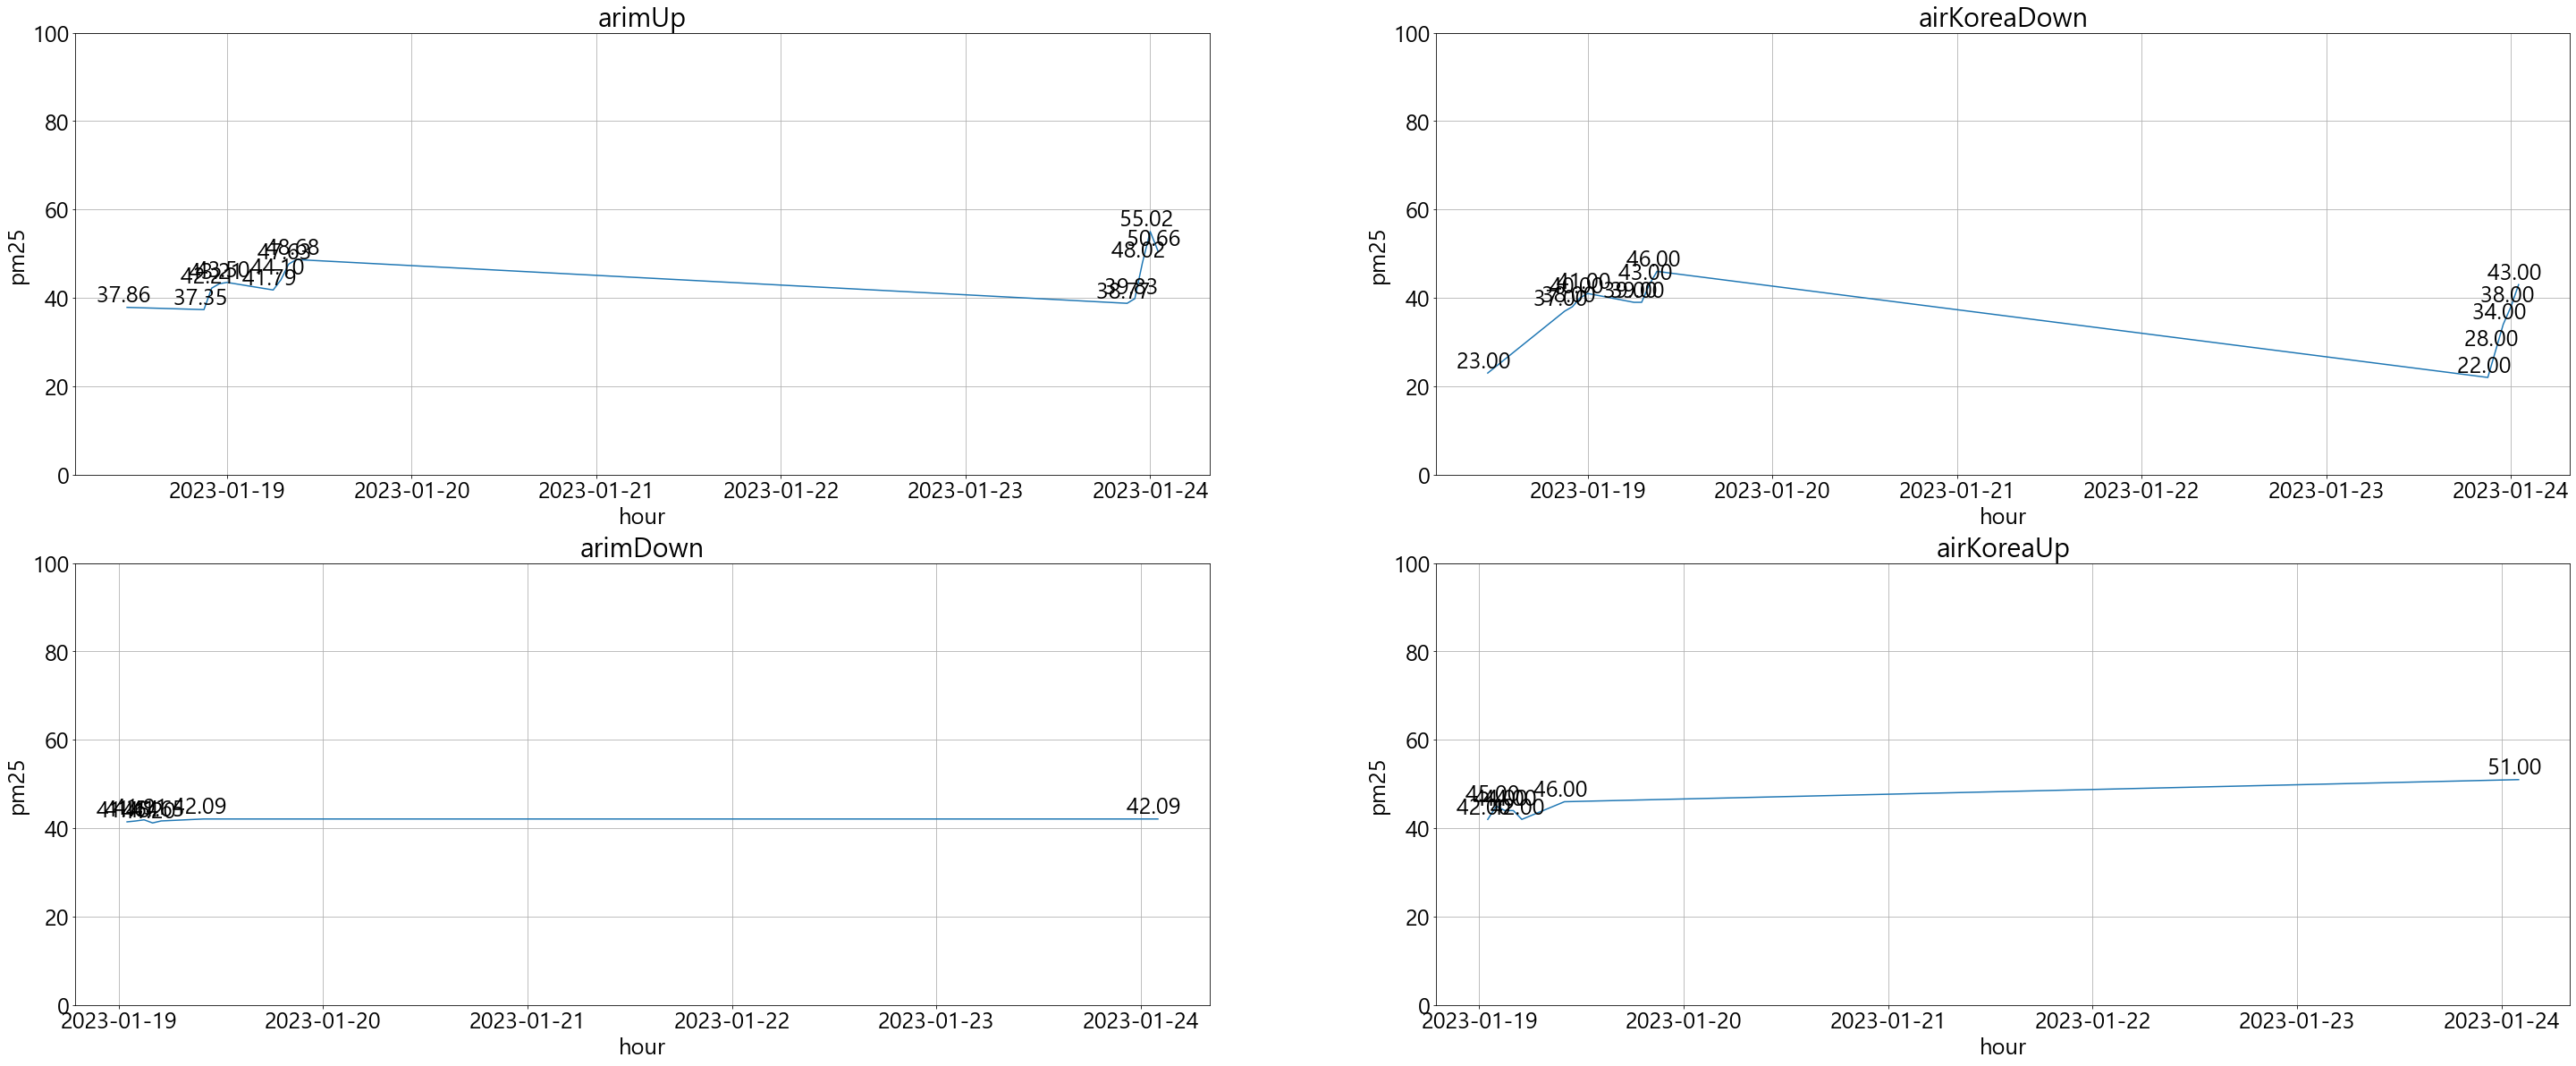

In [4]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.16~01.31.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()

# remove_out(arim_data_avg, ['pm25'])

# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.16~01.31.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# remove_out(airKorea_data_avg, ['pm25'])

# arim_data_avg.drop('2023-01-07 10:00:00', inplace=True)
arimDown = arim_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
airKoreaUp = airKorea_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index]

diff = arimDown.pm25 - airKoreaUp.pm25
print(diff.mean())

plt.plot(arimDown.index,arimDown.pm25,'*', arimDown.index, airKoreaUp.pm25, 'o')
plt.title("Difference between airm-airKorea")
plt.xlabel("Hour")
plt.ylabel("diff")
plt.show()

find_condition_pm25(airKoreaUp, arimDown)

7.90016520379338


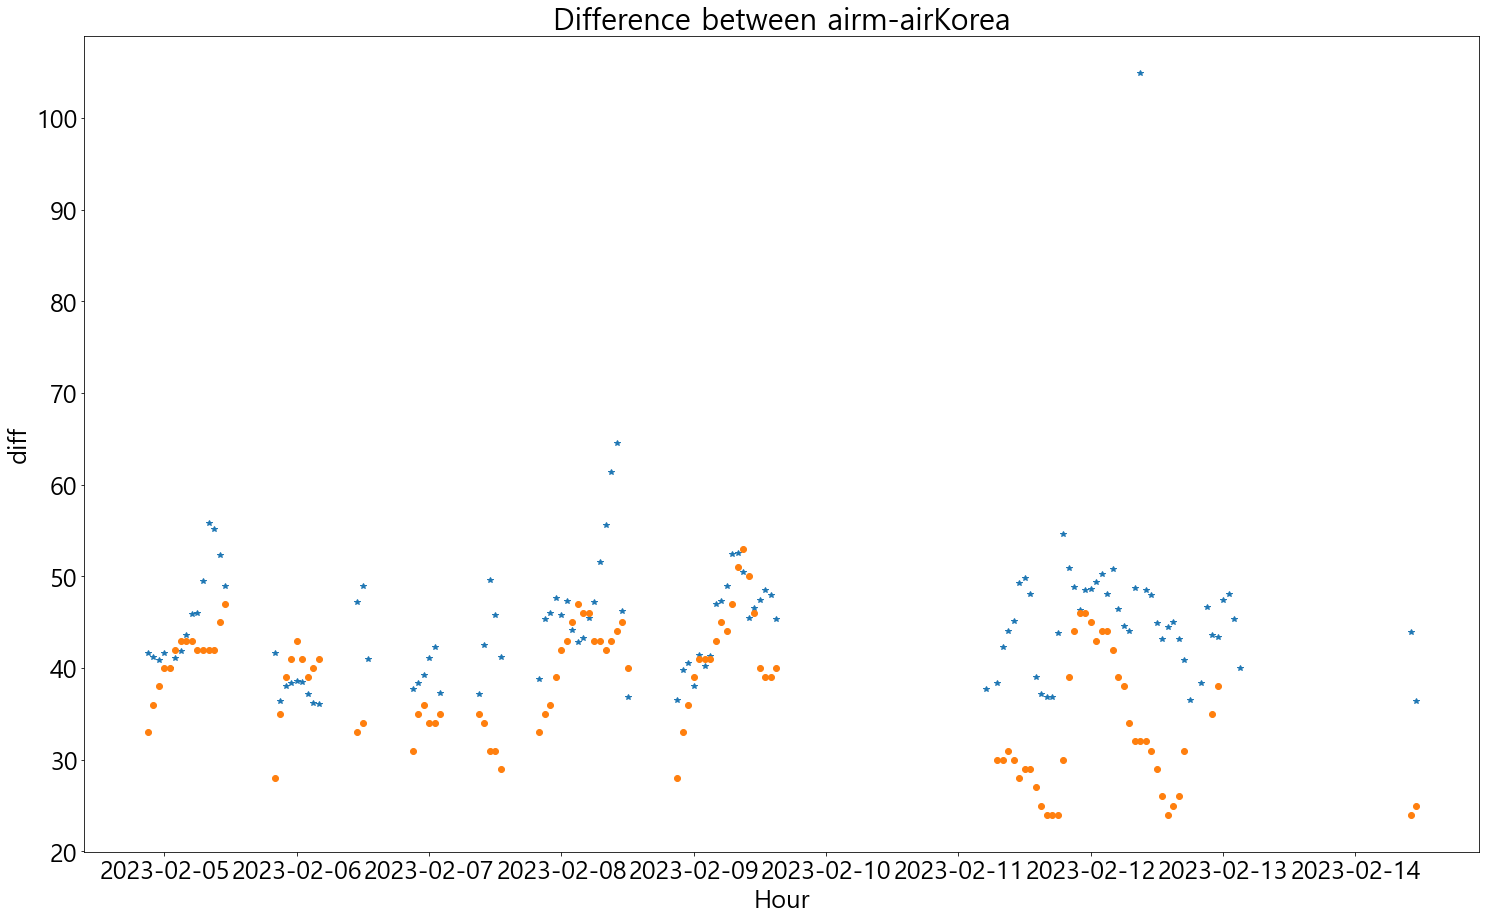

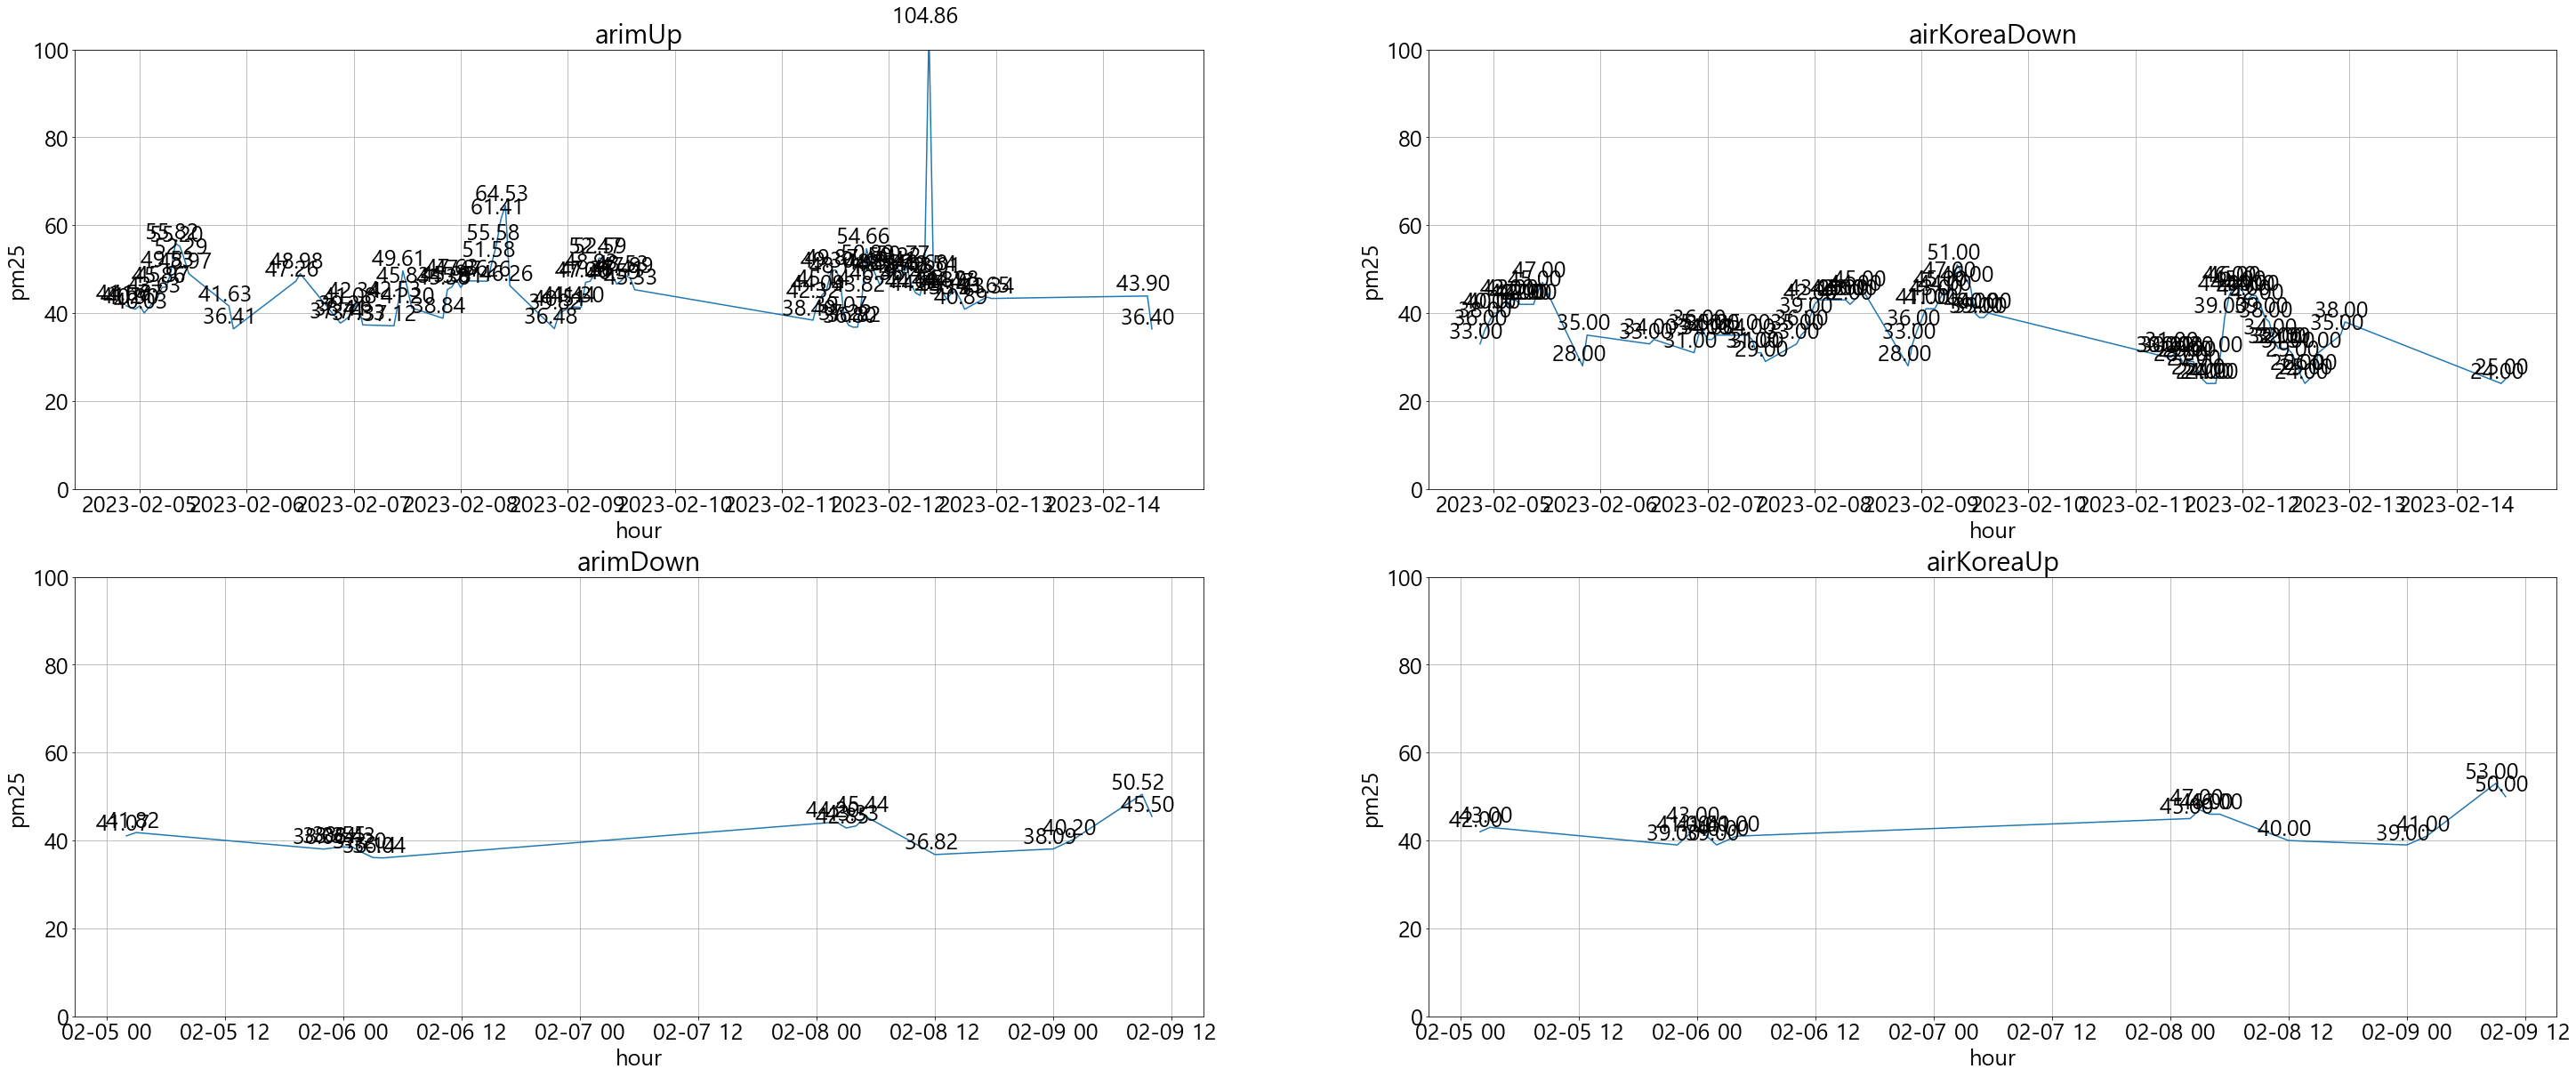

In [5]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_02.01~02.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()

# remove_out(arim_data_avg, ['pm25'])

# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_02.01~02.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# remove_out(airKorea_data_avg, ['pm25'])

# arim_data_avg.drop('2023-01-07 10:00:00', inplace=True)
arimDown = arim_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
airKoreaUp = airKorea_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index]

diff = arimDown.pm25 - airKoreaUp.pm25
print(diff.mean())

plt.plot(arimDown.index,arimDown.pm25,'*', arimDown.index, airKoreaUp.pm25, 'o')
plt.title("Difference between airm-airKorea")
plt.xlabel("Hour")
plt.ylabel("diff")
plt.show()

find_condition_pm25(airKoreaUp, arimDown)

12.523143492198427


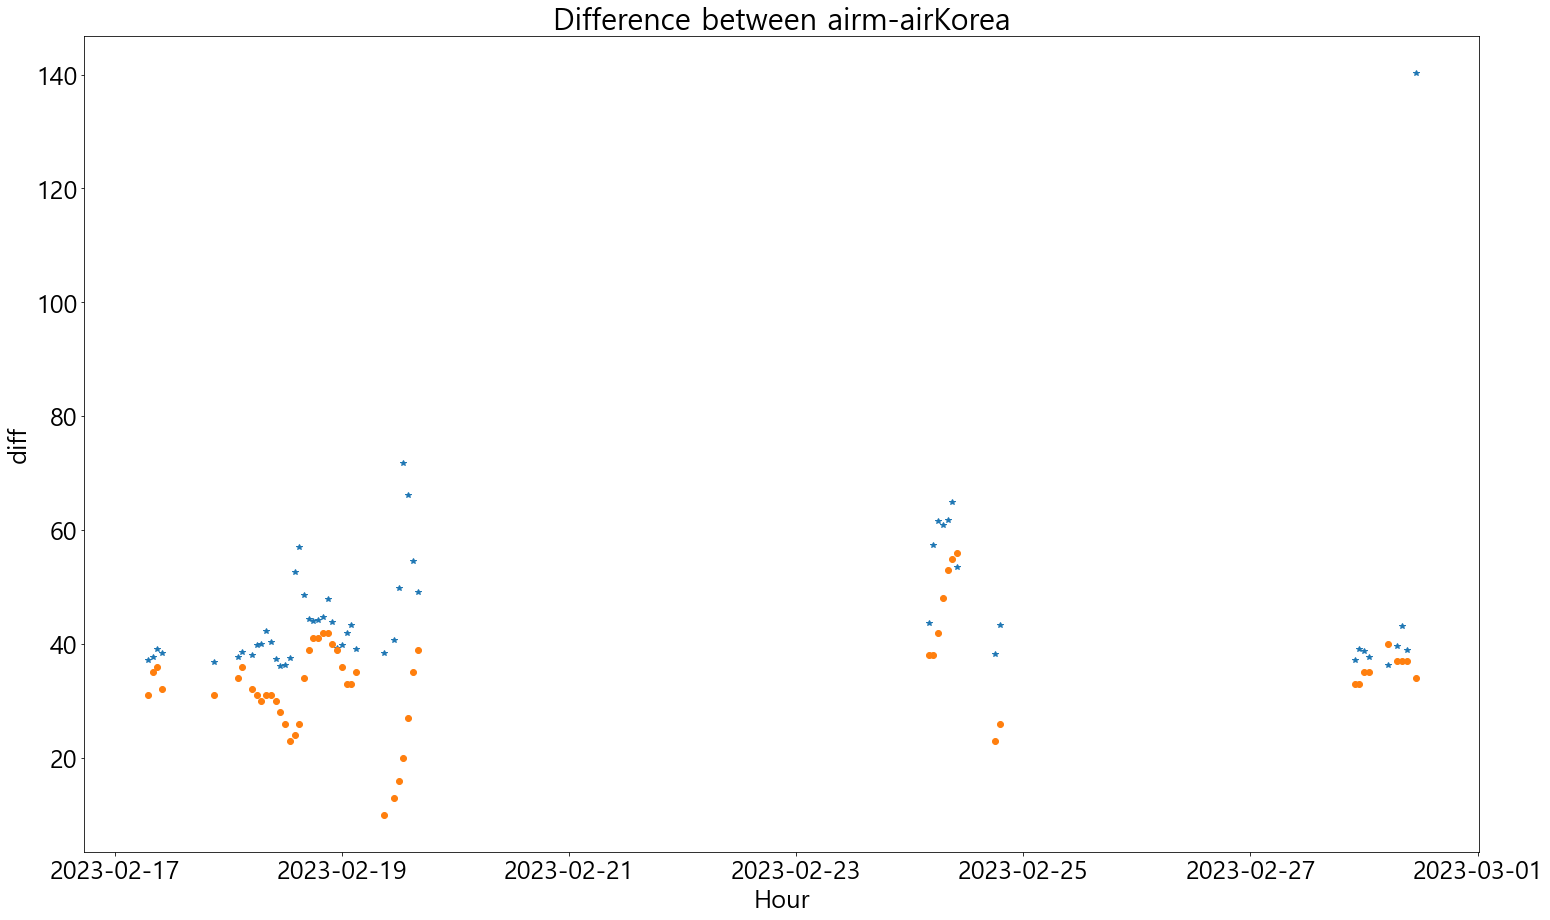

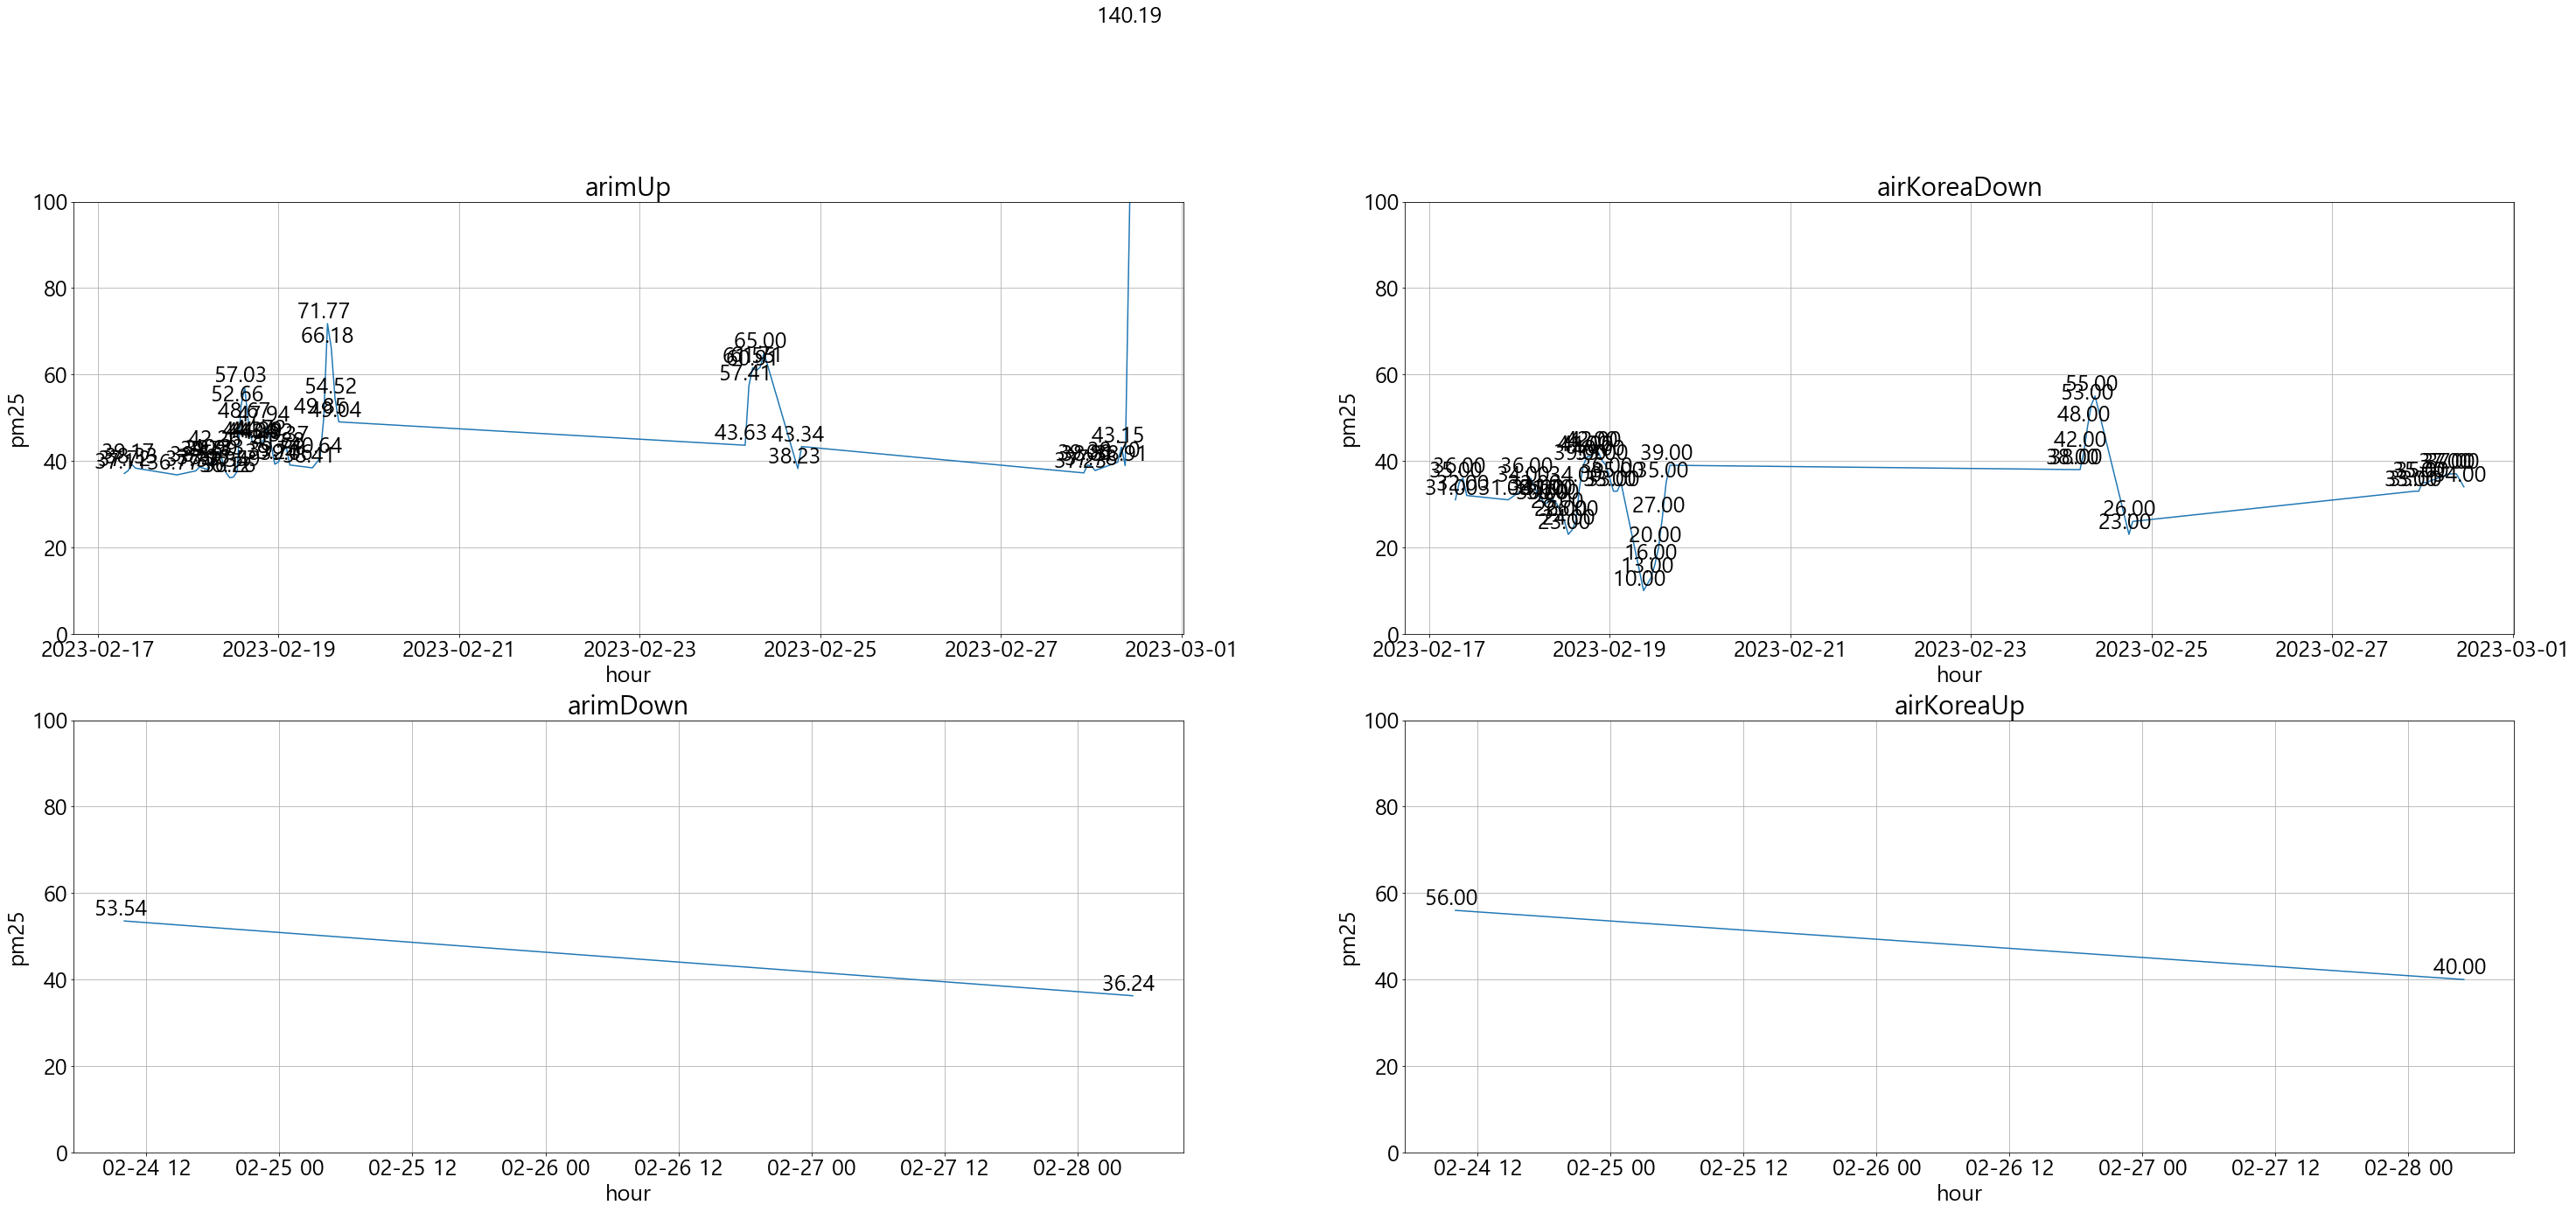

In [6]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_02.16~02.28.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()

# remove_out(arim_data_avg, ['pm25'])

# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_02.16~02.28.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# remove_out(airKorea_data_avg, ['pm25'])

# arim_data_avg.drop('2023-01-07 10:00:00', inplace=True)
arimDown = arim_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
airKoreaUp = airKorea_data_avg.loc[arim_data_avg.loc[arim_data_avg.pm25 >= 36].index]

diff = arimDown.pm25 - airKoreaUp.pm25
print(diff.mean())

plt.plot(arimDown.index,arimDown.pm25,'*', arimDown.index, airKoreaUp.pm25, 'o')
plt.title("Difference between airm-airKorea")
plt.xlabel("Hour")
plt.ylabel("diff")
plt.show()

find_condition_pm25(airKoreaUp, arimDown)